# **TIme Series Forcasting (Sales)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

## **Data Wragling**

In [2]:
df = pd.read_csv('train.csv')
df.head(10)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680
5,6,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600
6,7,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.2800
7,8,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.1520
8,9,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.5040
9,10,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.9000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [4]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format="%d/%m/%Y")

In [5]:
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='ME'))['Sales'].sum()
monthly_sales

Order Date
2015-01-31     14205.7070
2015-02-28      4519.8920
2015-03-31     55205.7970
2015-04-30     27906.8550
2015-05-31     23644.3030
2015-06-30     34322.9356
2015-07-31     33781.5430
2015-08-31     27117.5365
2015-09-30     81623.5268
2015-10-31     31453.3930
2015-11-30     77907.6607
2015-12-31     68167.0585
2016-01-31     18066.9576
2016-02-29     11951.4110
2016-03-31     32339.3184
2016-04-30     34154.4685
2016-05-31     29959.5305
2016-06-30     23599.3740
2016-07-31     28608.2590
2016-08-31     36818.3422
2016-09-30     63133.6060
2016-10-31     31011.7375
2016-11-30     75249.3995
2016-12-31     74543.6012
2017-01-31     18542.4910
2017-02-28     22978.8150
2017-03-31     51165.0590
2017-04-30     38679.7670
2017-05-31     56656.9080
2017-06-30     39724.4860
2017-07-31     38320.7830
2017-08-31     30542.2003
2017-09-30     69193.3909
2017-10-31     59583.0330
2017-11-30     79066.4958
2017-12-31     95739.1210
2018-01-31     43476.4740
2018-02-28     19920.9974
2

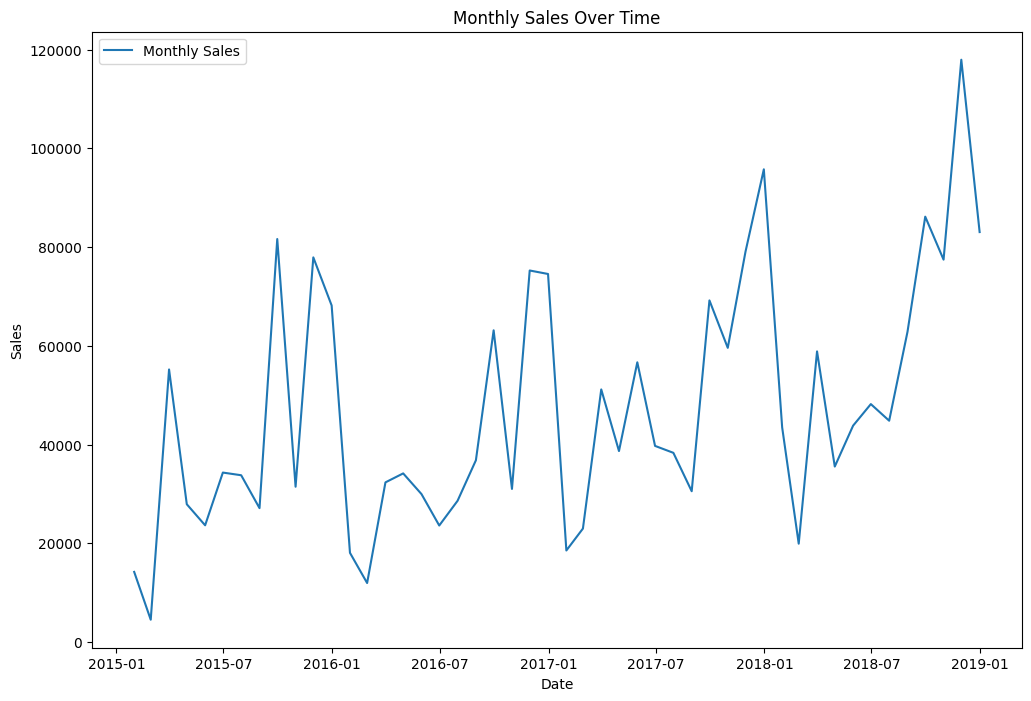

In [6]:
plt.figure(figsize=(12,8))
plt.plot(monthly_sales, label="Monthly Sales")
plt.title("Monthly Sales Over Time")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## **Decomposition**

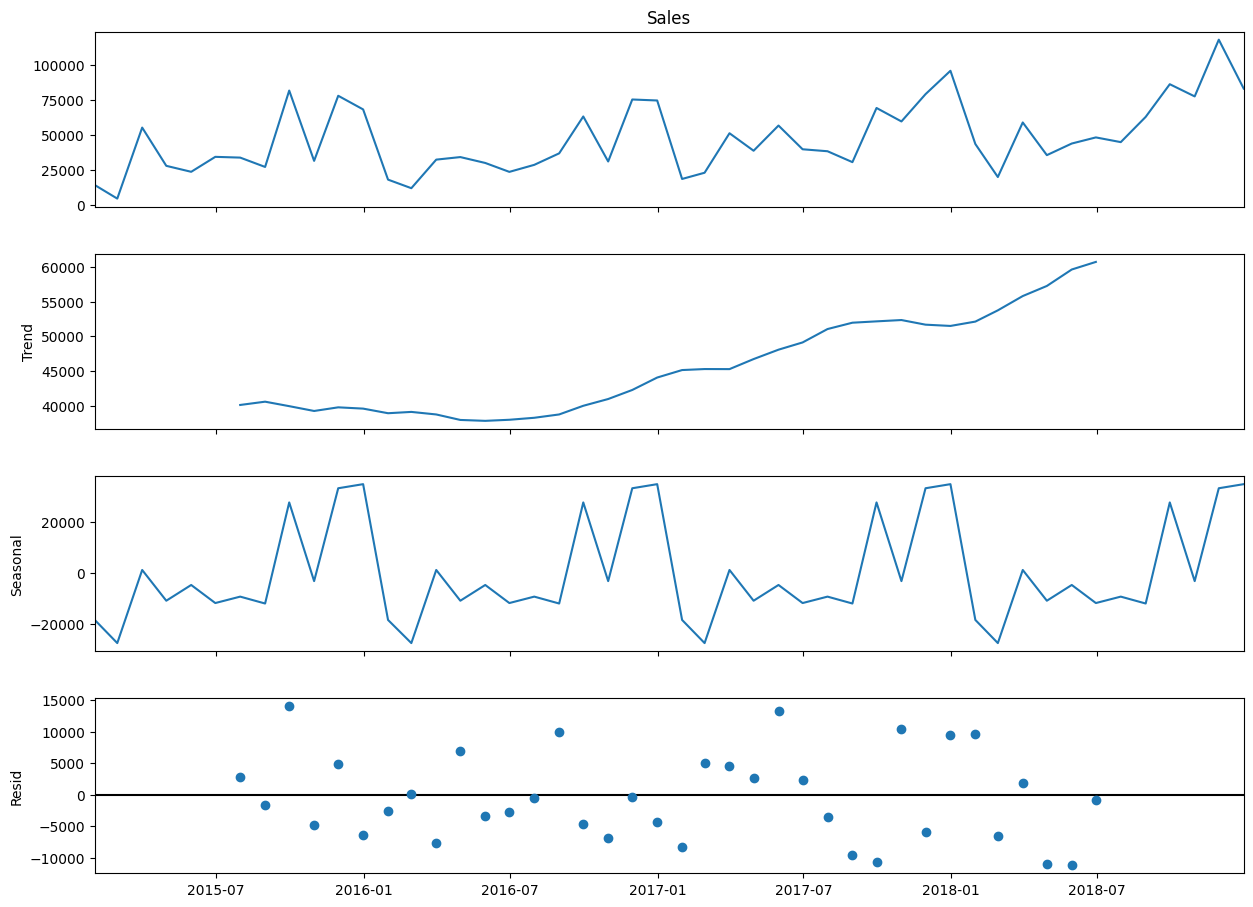

In [7]:
decomposition = seasonal_decompose(monthly_sales, model='additive')
fig = decomposition.plot()
fig.set_size_inches(14,10)
plt.show()

## **Stationary Validation**

In [8]:
def check_stationary(timeseries):
    result = adfuller(timeseries)
    print('Augmented Dickey-Fuller Test Results: ')
    print('ADF Statistic', result[0])
    print('p-value', result[1])
    print('Critical Values: ')

    for key, value in result[4].items():
        print(f'\t{key}: {value}')

    return result[1] < 0.05

is_stationary = check_stationary(monthly_sales)
print(f"\nTimes series is {'stationary' if is_stationary else 'non-stationary'}")

Augmented Dickey-Fuller Test Results: 
ADF Statistic -4.416136761430769
p-value 0.00027791039276670623
Critical Values: 
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064

Times series is stationary


## **Auto Regression Integrated Moving Average (ARIMA) Method**

In [9]:
auto_model = auto_arima(monthly_sales, start_p=0, start_q=0, max_p=5, max_q=5, m=12, seasonal=True, d=None, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1085.632, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1096.560, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1076.500, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1077.487, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1094.708, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1089.579, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1078.250, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1078.452, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1080.901, Time=0.04 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1079.864, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1084.035, Time=0.03 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1073.635, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1087.151, Time=0.02 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1075.267, Time=0.09 sec
 ARIMA(2,1,0)(1,0,1

In [10]:
model = ARIMA(monthly_sales, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
results = model.fit()
results

In [11]:
forecats_period = 12
forecast = results.get_forecast(steps=forecats_period)
mean_forcast = forecast.predicted_mean
mean_forcast

2019-01-31     71457.294754
2019-02-28     55170.675676
2019-03-31     75354.273335
2019-04-30     63712.967928
2019-05-31     68065.122548
2019-06-30     70562.386139
2019-07-31     68781.958288
2019-08-31     79738.550991
2019-09-30     94101.274954
2019-10-31     88767.503539
2019-11-30    113674.495429
2019-12-31     92191.072954
Freq: ME, Name: predicted_mean, dtype: float64

In [12]:
conf_int_95 = forecast.conf_int(alpha=0.05)
conf_int_80 = forecast.conf_int(alpha=0.20)
conf_int_70 = forecast.conf_int(alpha=0.30)

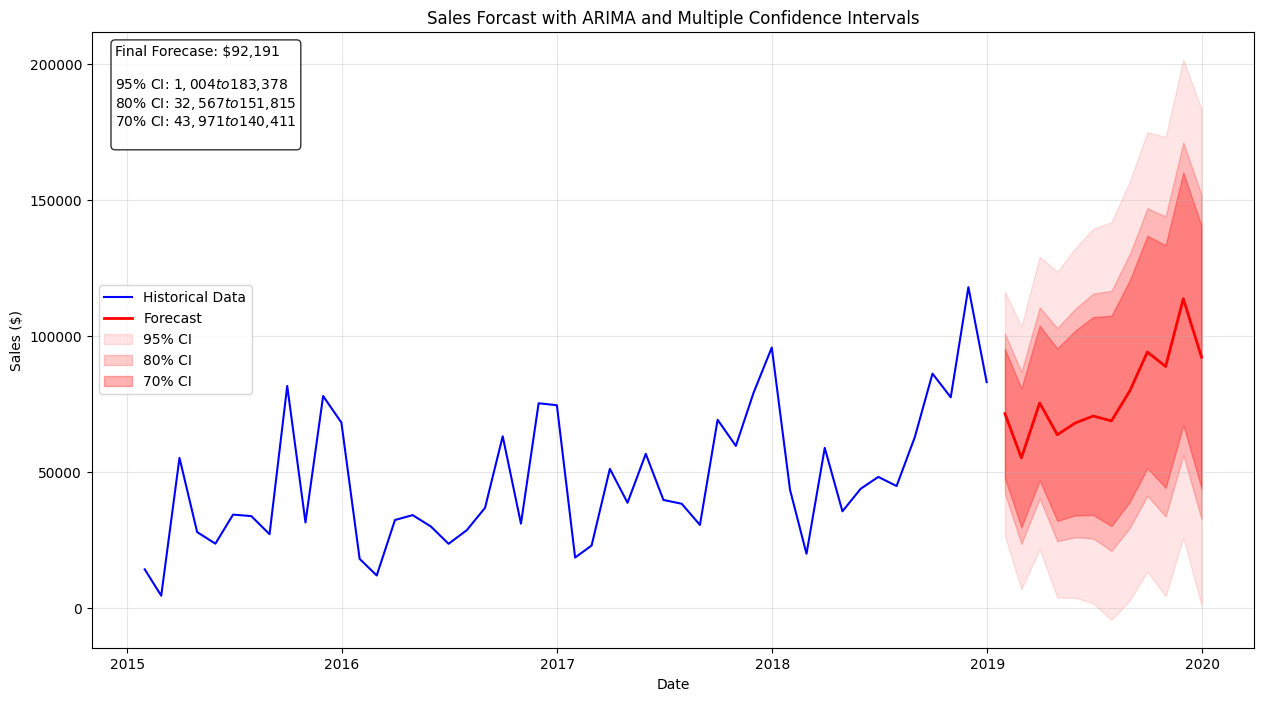

In [13]:
plt.figure(figsize=(15,8))

plt.plot(monthly_sales, label="Historical Data", color='blue')
plt.plot(mean_forcast, label="Forecast", color="red", linewidth=2)

plt.fill_between(mean_forcast.index, conf_int_95.iloc[:,0], conf_int_95.iloc[:,1], color="red", alpha=0.1, label='95% CI')
plt.fill_between(mean_forcast.index, conf_int_80.iloc[:,0], conf_int_80.iloc[:,1], color="red", alpha=0.2, label='80% CI')
plt.fill_between(mean_forcast.index, conf_int_70.iloc[:,0], conf_int_70.iloc[:,1], color="red", alpha=0.3, label='70% CI')

plt.title("Sales Forcast with ARIMA and Multiple Confidence Intervals")
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.grid(True, alpha=0.3)

last_forecast = mean_forcast.iloc[-1]
range_95_lower = conf_int_95.iloc[-1, 0]
range_95_upper = conf_int_95.iloc[-1, 1]
range_80_lower = conf_int_80.iloc[-1, 0]
range_80_upper = conf_int_80.iloc[-1, 1]
range_70_lower = conf_int_70.iloc[-1, 0]
range_70_upper = conf_int_70.iloc[-1, 1]

info_text = f'Final Forecase: ${last_forecast:,.0f}\n\n' \
            f'95% CI: ${range_95_lower:,.0f} to ${range_95_upper:,.0f}\n' \
            f'80% CI: ${range_80_lower:,.0f} to ${range_80_upper:,.0f}\n' \
            f'70% CI: ${range_70_lower:,.0f} to ${range_70_upper:,.0f}\n' 

plt.text(0.02,0.98, info_text, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor="white", alpha=0.8))
plt.show()


## **Model Performance Metrics**

In [14]:

mse = mean_squared_error(monthly_sales, results.fittedvalues)
mae = mean_absolute_error(monthly_sales, results.fittedvalues)
rmse = root_mean_squared_error(monthly_sales, results.fittedvalues)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (MSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

print('\nForecase Ranges for Final Period: ')
print(f"Point forecase: ${last_forecast:,.2f}")
print('\nConfidence Intervals: ')
print(f"95% CI: ${range_95_lower:,.0f} to ${range_95_upper:,.0f}")
print(f"80% CI: ${range_80_lower:,.0f} to ${range_80_upper:,.0f}")
print(f"70% CI: ${range_70_lower:,.0f} to ${range_70_upper:,.0f}")

print('\nInterval Widths as Percentage of Forecase: ')
print(f"95% CI: +- {((range_95_upper - range_95_lower) / 2 / last_forecast * 100):,.1f}%")
print(f"80% CI: +- {((range_80_upper - range_80_lower) / 2 / last_forecast * 100):,.1f}%")
print(f"70% CI: +- {((range_70_upper - range_70_lower) / 2 / last_forecast * 100):,.1f}%")


forecast_df = pd.DataFrame({
    'Forecast': mean_forcast,
    '95% Lower': conf_int_95.iloc[:, 0],
    '95% Upper': conf_int_95.iloc[:, 1],
    '80% Lower': conf_int_80.iloc[:, 1],
    '80% Upper': conf_int_80.iloc[:, 1],
    '70% Lower': conf_int_70.iloc[:, 1],
    '70% Upper': conf_int_70.iloc[:, 1],
})

print('Detailed Forecast With Confidence Intervals: \n')
print(forecast_df)

Mean Squared Error (MSE): 372198461.41
Root Mean Squared Error (MSE): 19292.45
Mean Absolute Error (MAE): 14432.38

Forecase Ranges for Final Period: 
Point forecase: $92,191.07

Confidence Intervals: 
95% CI: $1,004 to $183,378
80% CI: $32,567 to $151,815
70% CI: $43,971 to $140,411

Interval Widths as Percentage of Forecase: 
95% CI: +- 98.9%
80% CI: +- 64.7%
70% CI: +- 52.3%
Detailed Forecast With Confidence Intervals: 

                 Forecast     95% Lower      95% Upper      80% Lower  \
2019-01-31   71457.294754  26519.448469  116395.141039  100840.573076   
2019-02-28   55170.675676   6856.399024  103484.952328   86761.683149   
2019-03-31   75354.273335  21594.176475  129114.370194  110506.111245   
2019-04-30   63712.967928   3787.033027  123638.902828  102896.430631   
2019-05-31   68065.122548   3753.333458  132376.911637  110116.341162   
2019-06-30   70562.386139   1722.863559  139401.908718  115574.130553   
2019-07-31   68781.958288  -4308.035992  141871.952568  11657

## **Holt Winters Exponential Smoothing**

In [15]:
models = []
specifications = [
    {
        'name': 'Fixed Parameters',
        'model': ExponentialSmoothing(
            monthly_sales, seasonal_periods=12, trend='add', seasonal='add', damped_trend=True
        ).fit(
            smoothing_level=0.2,
            smoothing_trend=0.1,
            smoothing_seasonal=0.1,
            damping_trend=0.98,
            optimized=False
        )
    },
    {
        'name': "Multiplicative Seasonal",
        'model': ExponentialSmoothing(
           monthly_sales, seasonal_periods=12, trend='add', seasonal='mul', damped_trend=True
        ).fit(
            smoothing_level=0.2,
            smoothing_trend=0.1,
            smoothing_seasonal=0.1,
            damping_trend=0.98,
            optimized=False
        )
    },
    {
        'name': "Multiplicative Trend",
        'model': ExponentialSmoothing(
             monthly_sales, seasonal_periods=12, trend='mul', seasonal='add', damped_trend=True
        ).fit(
            smoothing_level=0.2,
            smoothing_trend=0.1,
            smoothing_seasonal=0.1,
            damping_trend=0.98,
            optimized=False
        )
    }
]

In [16]:
results = []
for spec in specifications:
    model = spec['model']
    name = spec['name']

    mse = mean_squared_error(monthly_sales, model.fittedvalues)
    rmse = root_mean_squared_error(monthly_sales, model.fittedvalues)
    mae = mean_absolute_error(monthly_sales, model.fittedvalues)

    results.append({
        'name': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'model': model
    })

In [17]:
results

[{'name': 'Fixed Parameters',
  'MSE': 95718775.16253917,
  'RMSE': 9783.597250630219,
  'MAE': 7831.269048033438,
  'model': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x214d0b5b9d0>},
 {'name': 'Multiplicative Seasonal',
  'MSE': 138266312.46547326,
  'RMSE': 11758.669672436303,
  'MAE': 8762.041257003448,
  'model': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x214d0a8afd0>},
 {'name': 'Multiplicative Trend',
  'MSE': 95302324.09887366,
  'RMSE': 9762.290924720162,
  'MAE': 7841.89557727872,
  'model': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x214d0bde510>}]

In [18]:
best_model = min(results, key=lambda x: x['RMSE'])
hw_model = best_model['model']
hw_forecast = hw_model.forecast(12)

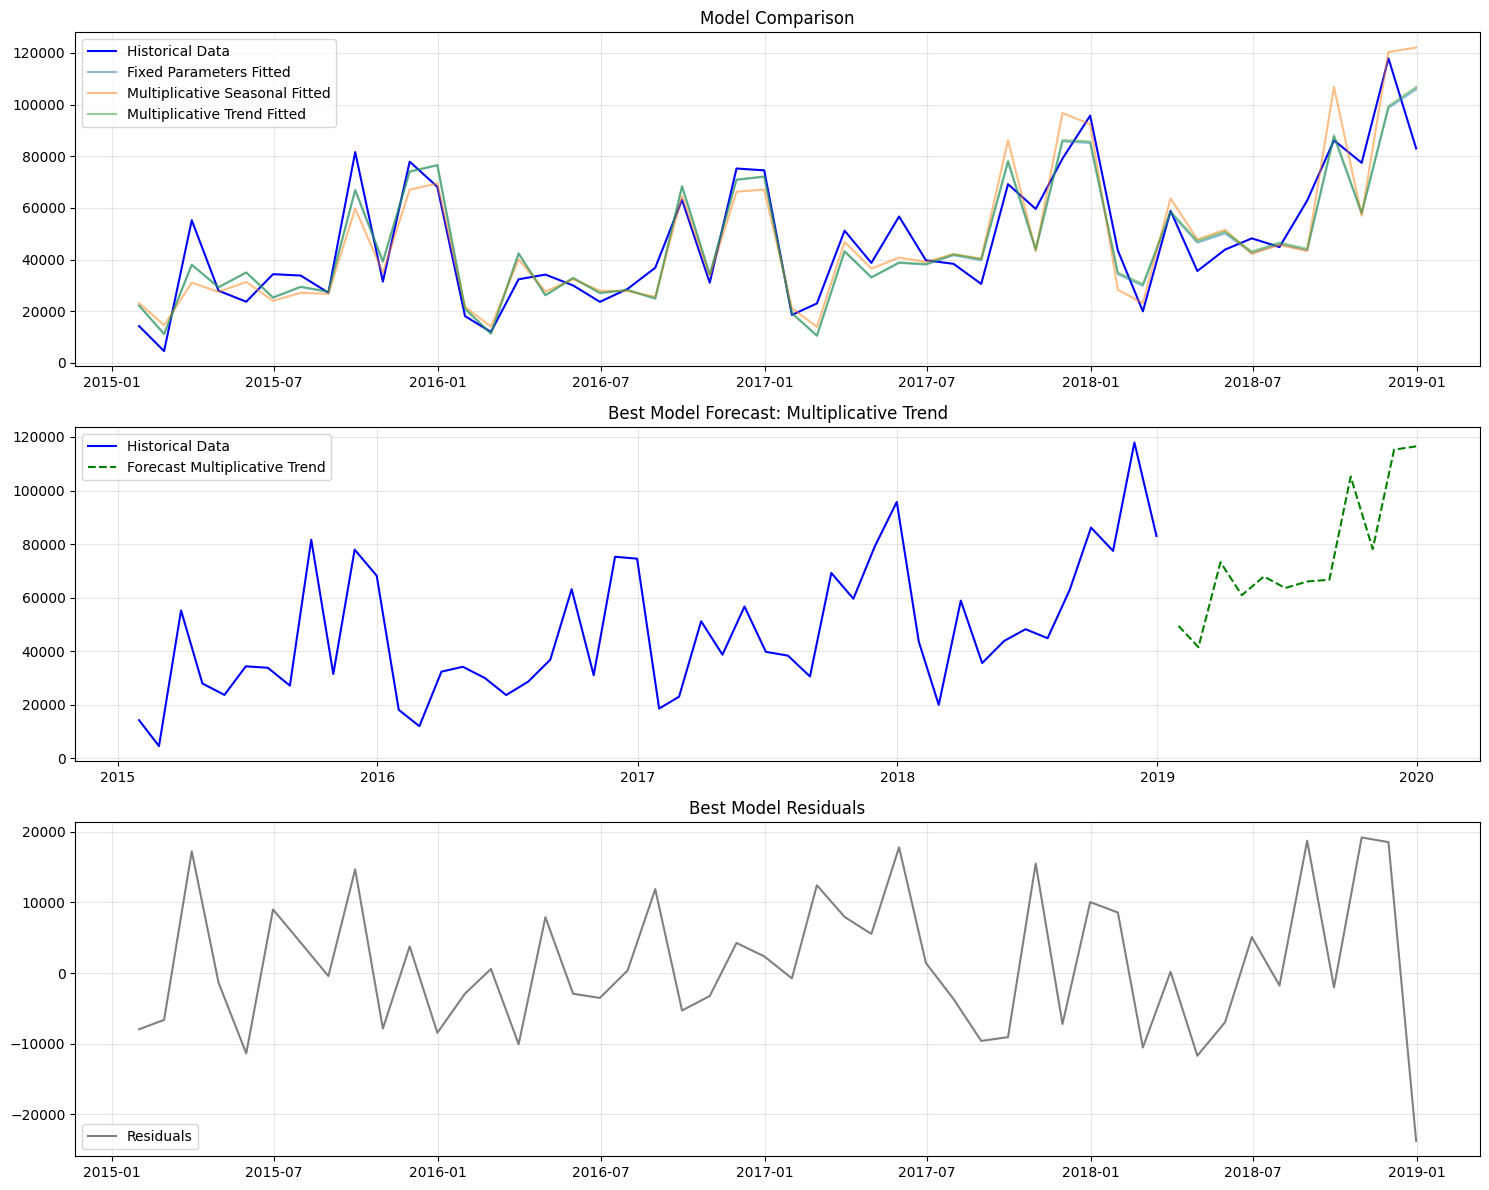

In [19]:
plt.figure(figsize=(15,12))

plt.subplot(3,1,1)
plt.plot(monthly_sales.index, monthly_sales, label="Historical Data", color='blue')
for result in results:
    plt.plot(result['model'].fittedvalues.index, result['model'].fittedvalues, label=f"{result['name']} Fitted", alpha=0.5)

plt.title('Model Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3,1,2)
plt.plot(monthly_sales.index, monthly_sales, label="Historical Data", color='blue')
plt.plot(hw_forecast.index, hw_forecast, label=f"Forecast {best_model['name']}", color="green", linestyle="--")
plt.title(f"Best Model Forecast: {best_model['name']}")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3,1,3)
residuals = monthly_sales - hw_model.fittedvalues
plt.plot(monthly_sales.index, residuals, label="Residuals", color="gray")
plt.title('Best Model Residuals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## **Model Comparison**

In [20]:
for result in results:
    print(f"\n{result['name']}:")
    print(f"MSE: ${result['MSE']:.2f}")
    print(f"RMSE: ${result['RMSE']:.2f}")
    print(f"MAE: ${result['MAE']:.2f}")

print(f"\nBest Model: {best_model['name']}")
print(f"best Root Mean Square Error ${best_model['RMSE']:.2f}")


Fixed Parameters:
MSE: $95718775.16
RMSE: $9783.60
MAE: $7831.27

Multiplicative Seasonal:
MSE: $138266312.47
RMSE: $11758.67
MAE: $8762.04

Multiplicative Trend:
MSE: $95302324.10
RMSE: $9762.29
MAE: $7841.90

Best Model: Multiplicative Trend
best Root Mean Square Error $9762.29


## **Model Parameters**

In [21]:
print(f"- Smoothing level: {hw_model.params['smoothing_level']:.3f}")
print(f"- Smoothing trend: {hw_model.params['smoothing_trend']:.3f}")
print(f"- Seasonal Smoothing: {hw_model.params['smoothing_seasonal']:.3f}")
print(f"- Damping paramter: {hw_model.params['damping_trend']:.3f}")

- Smoothing level: 0.200
- Smoothing trend: 0.100
- Seasonal Smoothing: 0.100
- Damping paramter: 0.980


In [22]:
hw_forecast

2019-01-31     49435.711479
2019-02-28     41459.506838
2019-03-31     73220.555712
2019-04-30     60904.078997
2019-05-31     67886.536597
2019-06-30     63574.157506
2019-07-31     66020.931715
2019-08-31     66663.177848
2019-09-30    105201.488326
2019-10-31     78140.769889
2019-11-30    115255.953319
2019-12-31    116513.155267
Freq: ME, dtype: float64

In [24]:
final_results = pd.DataFrame({
    'Actual': monthly_sales,
    'Fitted': hw_model.fittedvalues,
    'Residuals': residuals
})

final_results

,Actual,Fitted,Residuals
Order Date,,,
2015-01-31,14205.7070,22155.386037,-7949.679037
2015-02-28,4519.8920,11146.811114,-6626.919114
2015-03-31,55205.7970,37975.018760,17230.778240
2015-04-30,27906.8550,29267.192066,-1360.337066
2015-05-31,23644.3030,35011.240872,-11366.937872
2015-06-30,34322.9356,25323.862069,8999.073531
2015-07-31,33781.5430,29471.746667,4309.796333
2015-08-31,27117.5365,27556.862748,-439.326248
2015-09-30,81623.5268,66942.870651,14680.656149
